# Prophet Prediction

In [1]:
# Libraries
import pandas as pd
import numpy as np
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns



Drug Classes:
- ALLERGY, SYSTEMIC & NASAL
- DERMATOLOGICS
- GI PRODUCTS
- IMMUNOLOGY
- MULTIPLE SCLEROSIS
- NERVOUS SYSTEM DISORDERS
- ONCOLOGICS
- OPHTHALMOLOGY, GENERAL
- OTHER CNS
- OTHER HAEMATOLOGICALS
- VACCINES (PURE, COMB, OTHER)

In [2]:
classes = ['ALLERGY, SYSTEMIC & NASAL', 'DERMATOLOGICS', 'GI PRODUCTS', 'IMMUNOLOGY', 'MULTIPLE SCLEROSIS', 'NERVOUS SYSTEM DISORDERS',
           'ONCOLOGICS', 'OPHTHALMOLOGY, GENERAL', 'OTHER CNS', 'OTHER HAEMATOLOGICALS', 'VACCINES (PURE, COMB, OTHER)']


In [3]:
# Loading dataset
dataframe = pd.read_csv('../2 Processed_Data/drugs_pct_changes_monthly.csv')

# Only NDCs that have full period
last_period = dataframe[(dataframe.Year == 2020) & (dataframe.Month == 7)].NDC.unique()
first_period = dataframe[(dataframe.Year == 2014) & (dataframe.Month == 8)].NDC.unique()
dataframe.Date = pd.to_datetime(dataframe.Date, format='%Y_%m')
selected_NDC = list(set(last_period).intersection(first_period)) 
dataframe = dataframe[dataframe.NDC.isin(selected_NDC)]

# Fill in the pct change NA by 0 (first values)
dataframe.Pct_change = dataframe.Pct_change.fillna(0)

# Fill in the Previous_TRx NA by latest value (first values)
dataframe.Previous_TRx = dataframe.Previous_TRx.fillna(method='ffill')

# Dropping before 2015 because 2014 is not good
dataframe = dataframe[dataframe.Date >= pd.to_datetime('2015-01-01')]

dataframe.head()

,NDC,Manufacturer,Product,Product Launch Date,Estimated LOE Date,Major Class,Acute/Chronic,Prod Form,Pack Size,Pack Quantity,Date,Year,Month,TRx,Previous_TRx,TRx_cumulative,WAC,Pct_change,Changed
605,2322730,Eli Lilly and Co,STRATTERA 12/2002 LLY,12/1/2002 0:00,May-17,ADHD,CHRONIC,ORALS,1,30.0,2015-01-01,2015,1,11297,11566.0,11297.0,9.29,0.000000,0
606,2322730,Eli Lilly and Co,STRATTERA 12/2002 LLY,12/1/2002 0:00,May-17,ADHD,CHRONIC,ORALS,1,30.0,2015-02-01,2015,2,10622,11297.0,21919.0,9.29,0.000000,0
607,2322730,Eli Lilly and Co,STRATTERA 12/2002 LLY,12/1/2002 0:00,May-17,ADHD,CHRONIC,ORALS,1,30.0,2015-03-01,2015,3,12012,10622.0,33931.0,9.29,0.000000,0
608,2322730,Eli Lilly and Co,STRATTERA 12/2002 LLY,12/1/2002 0:00,May-17,ADHD,CHRONIC,ORALS,1,30.0,2015-04-01,2015,4,11520,12012.0,45451.0,9.29,0.000000,0
609,2322730,Eli Lilly and Co,STRATTERA 12/2002 LLY,12/1/2002 0:00,May-17,ADHD,CHRONIC,ORALS,1,30.0,2015-05-01,2015,5,10866,11520.0,56317.0,10.21,0.099031,1


In [4]:
# Updating NDC that do not have LOE date to a future LOE date
dataframe.loc[dataframe['Estimated LOE Date'] == 'Unspecified', 'Estimated LOE Date'] = 'May-24'

# Getting rid of NDC that are too close to their LOE date
dataframe['Estimated LOE Date'] = pd.to_datetime(dataframe['Estimated LOE Date'], format='%b-%y')
dataframe = dataframe[dataframe['Estimated LOE Date'] >= pd.to_datetime('2020-07-01')]

In [5]:
def prophet_model(data, test_date=None, prediction_period=365, changepoint_prior_scale=.05):

    # Initiating test variable
    test_set = None

    # Reformating dataset for prophet
    df_prophet = data[['Date', 'Sales weighted WAC']].copy()
    df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Sales weighted WAC': 'y'})

    # Creating Prophet model
    model = Prophet(changepoint_prior_scale=changepoint_prior_scale, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)

    # Fitting model to training data excluding test dates
    if test_date is not None:
        model.fit(df_prophet[df_prophet.ds < pd.to_datetime(test_date)])
    else:
        model.fit(df_prophet)

    # Building predictions for train and test dates
    future = model.make_future_dataframe(periods=prediction_period, freq='MS')
    forecast = model.predict(future)

    # Ordering columns
    forecast = forecast[['ds', 'yhat'] + [c for c in forecast if c not in ['ds', 'yhat']]]

    # Creating test period dataset only
    if test_date is not None:
        forecast_test = model.predict(df_prophet)
        forecast_test['y'] = data['Sales weighted WAC'].values
        test_set = forecast_test[forecast_test.ds >= pd.to_datetime(test_date)][['ds', 'y', 'yhat']].copy()
        
    # Return model (for plotting), full forecast, and test period dataset
    return model, forecast, test_set

Size:  42
VACCINES (PURE, COMB, OTHER) 250.0649250553827
MAE on test period:  11.55865253300149


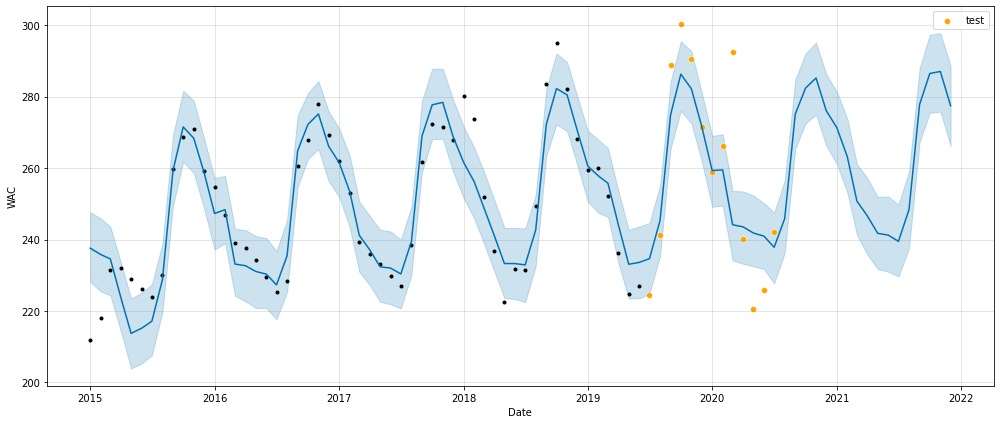

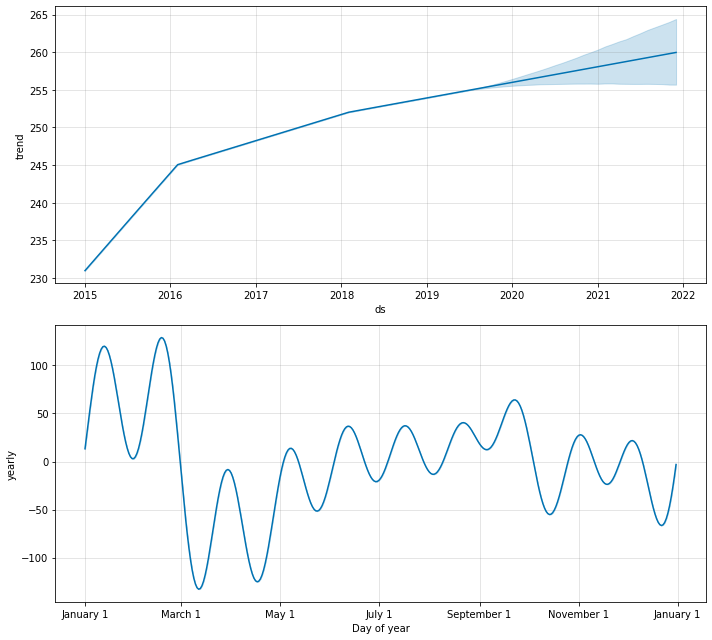

In [6]:
selected_class = classes[-1]
    
# Filtering for a single class
data_class = dataframe[dataframe['Major Class'] == selected_class].copy()
print('Size: ', len(data_class.NDC.unique()))


# Helper function to compute the weighted WAC 
def weigthed_average(data, quantity, weights):
    try:
        return (data[quantity] * data[weights]).sum() / data[weights].sum()
    except ZeroDivisionError:
        return data[quantity]


# Creating a sales column
data_class['Sales'] = data_class['WAC'] * data_class['TRx']
df = data_class.groupby('Date').apply(weigthed_average, 'WAC', 'Sales').to_frame(name = 'Sales weighted WAC')
df.reset_index(inplace=True)
print(selected_class, df['Sales weighted WAC'].mean())

model, forecast, test_set = prophet_model(data=df, test_date='2019-07-01', prediction_period=30, changepoint_prior_scale=.05)

# plotting results
fig, ax = plt.subplots(figsize=(14, 6))
model.plot(forecast, ax=ax);
if test_set is not None:
    sns.scatterplot(x= test_set.ds, y=test_set.y, color='orange', label='test')
    plt.legend()
    print('MAE on test period: ', mean_absolute_error(test_set.y, test_set.yhat))

plt.xlabel('Date')
plt.ylabel('WAC')
plt.show()

# plotting components
model.plot_components(forecast, figsize=(10, 9))
plt.show()

forecast = forecast.rename(columns={'ds': 'date'})
forecast.to_csv(f'Results/Method 2/{selected_class}.csv', index=False)



